In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Aplicando o pre-processamento nas imagens

In [32]:
img1_path = "imagens/campus_quixada1.png"
img2_path = "imagens/campus_quixada2.png"

img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

h1, w1, _ = img1.shape
img1_resized = cv2.resize(img1, (int(w1 * 0.5), int(h1 * 0.5)))

h2, w2, _ = img2.shape
img2_resized = cv2.resize(img2, (int(w2 * 0.5), int(h2 * 0.5)))

img1_gray = cv2.cvtColor(img1_resized, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2_resized, cv2.COLOR_BGR2GRAY)

### Descritores para encontrar correspondências entre imagens

In [33]:
def match_images(im1,im2,kp1,kp2,des1,des2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])

    if len(good) >= 4:
# Extrair localizações dos bons matches
        pts1 = []
        pts2 = []
        for m in good:
            pts1.append(kp1[m[0].queryIdx].pt)
            pts2.append(kp2[m[0].trainIdx].pt)

        # matrix points
        points1 = np.float32(pts1).reshape(-1, 1, 2)
        points2 = np.float32(pts2).reshape(-1, 1, 2)
    else:
        raise AssertionError("No enough keypoints.")
    return points1, points2

def bf_orb(img1,img2):
    orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)
    
    return match_images(img1,img2,kp1,kp2,des1,des2)

def bf_sift(img1,img2):
    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    return match_images(img1,img2,kp1,kp2,des1,des2)

def bf_surf(img1,img2):
	# Initiate SURF detector
    surf = cv2.xfeatures2d_SURF.create(400)

	# find the keypoints and descriptors with SIFT
    kp1, des1 = surf.detectAndCompute(img1,None)
    kp2, des2 = surf.detectAndCompute(img2,None)

    return match_images(img1,img2,kp1,kp2,des1,des2)

def bf_brief(img1,img2):
    """
    O BRIEF em si não inclui uma etapa de detecção de pontos de interesse; 
    ele apenas descreve as regiões já identificadas por outro algoritmo 
    (como FAST, SURF, ou SIFT).
    """

    # Initiate FAST detector
    star = cv2.xfeatures2d.StarDetector_create()

    # Initiate BRIEF extractor
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

    # find the keypoints with STAR
    kp1 = star.detect(img1,None)

    # compute the descriptors with BRIEF
    kp1, des1 = brief.compute(img1, kp1)

    kp2 = star.detect(img2,None)
    kp2, des2 = brief.compute(img2, kp2)

    return match_images(img1,img2,kp1,kp2,des1,des2)

In [34]:
# Encontrar pontos de interesse
points1_sift, points2_sift = bf_sift(img1_gray, img2_gray)
points1_orb, points2_orb = bf_orb(img1_gray, img2_gray)
points1_surf, points2_surf = bf_surf(img1_gray, img2_gray)
points1_brief, points2_brief = bf_brief(img1_gray, img2_gray)

# Encontrar homografia usando RANSAC
transformation_matrix_sift, inliers_sift = cv2.findHomography(points1_sift, points2_sift, cv2.RANSAC)
transformation_matrix_orb, inliers_orb = cv2.findHomography(points1_orb, points2_orb, cv2.RANSAC)
transformation_matrix_surf, inliers_surf = cv2.findHomography(points1_surf, points2_surf, cv2.RANSAC)
transformation_matrix_brief, inliers_brief = cv2.findHomography(points1_brief, points2_brief, cv2.RANSAC)

print(transformation_matrix_sift)
print(transformation_matrix_orb)
print(transformation_matrix_surf)
print(transformation_matrix_brief)

[[ 1.26395803e+00 -3.45736913e-02 -1.59645454e+02]
 [ 1.27264265e-01  1.15471436e+00 -4.35268974e+01]
 [ 4.52294026e-04 -7.37457448e-06  1.00000000e+00]]
[[ 1.26091381e+00 -3.57496273e-02 -1.58896194e+02]
 [ 1.27510888e-01  1.14981562e+00 -4.30823722e+01]
 [ 4.51218907e-04 -1.54105215e-05  1.00000000e+00]]
[[ 1.26121979e+00 -3.50098334e-02 -1.58927943e+02]
 [ 1.26440415e-01  1.15212987e+00 -4.29748447e+01]
 [ 4.50427315e-04 -1.03612517e-05  1.00000000e+00]]
[[ 1.26267453e+00 -3.26832301e-02 -1.59606769e+02]
 [ 1.25509216e-01  1.15754618e+00 -4.34407324e+01]
 [ 4.47209954e-04  2.56100266e-06  1.00000000e+00]]


(905, 492)
[174, 43]
(906, 492)
[175, 43]
(905, 491)
[174, 42]
(904, 492)
[173, 43]


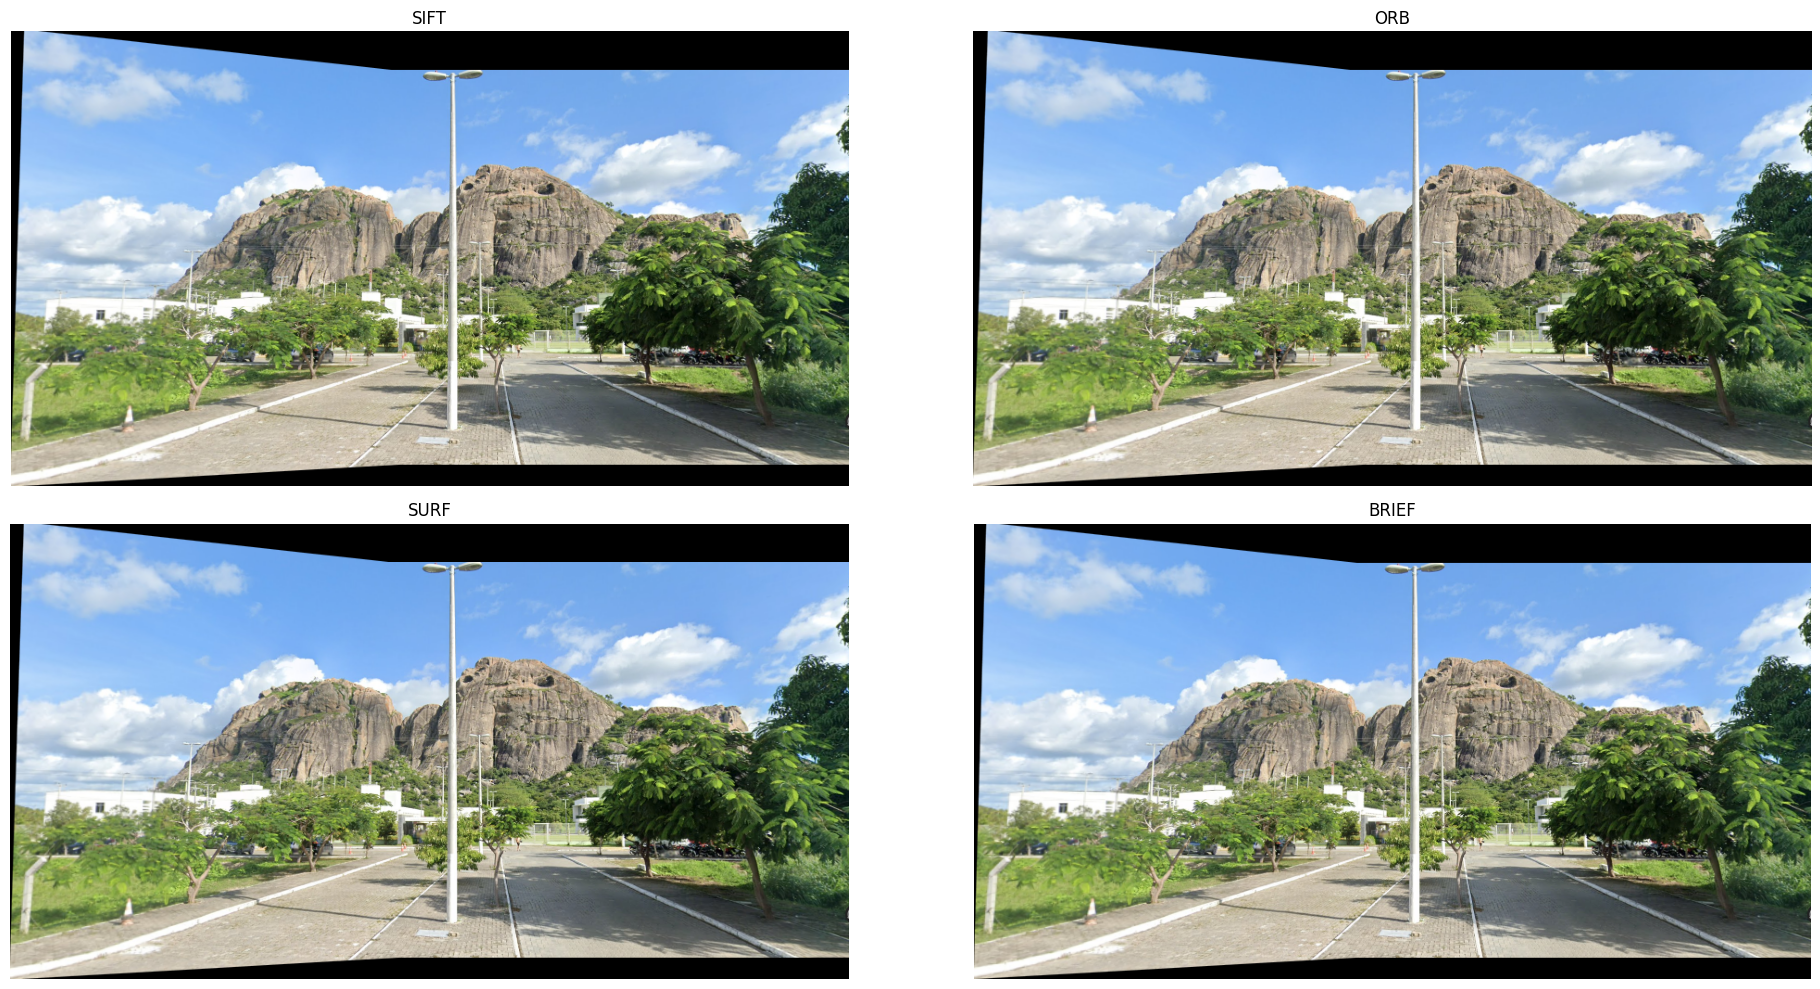

In [35]:
def apply_homography(img1, img2, transformation_matrix):
    
    h1, w1, _ = img1.shape
    h2, w2, _ = img2.shape

    corners = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)

    # Aplicar a transformação de perspectiva 
    # Calcular onde os cantos da imagem 1 estarão na nova perspectiva
    transformed_corners = cv2.perspectiveTransform(corners, transformation_matrix)

    # Determinar o novo "retângulo" que a imagem combinada ocupará
    [x_min, y_min] = np.int32(transformed_corners.min(axis=0).ravel())
    [x_max, y_max] = np.int32(transformed_corners.max(axis=0).ravel())

    # Tamanho deve incluir a imagem 2
    x_max = max(w2, x_max)
    y_max = max(h2, y_max)

    # Distância de translação necessária para ajustar as coordenadas, evitando que as partes da imagem fiquem fora dos limites
    t_distance = [-x_min, -y_min]

    # Matriz 3x3 é usada para mover a imagem transformada para as novas coordenadas
    translation_matrix = np.array([[1, 0, t_distance[0]], [0, 1, t_distance[1]], [0, 0, 1]]) 

    mult_matrix = translation_matrix @ transformation_matrix # Multiplicação de matrizes

    # Tamanho final da imagem
    final_size = (x_max - x_min, y_max - y_min)

    # Aplicar a transformação de perspectiva
    combined_img = cv2.warpPerspective(img1_resized, mult_matrix, final_size)
    print(final_size)
    print(t_distance)

    # Adicionar a imagem 2 na imagem combinada
    combined_img[t_distance[1]:h2+t_distance[1], t_distance[0]:w2+t_distance[0]] = img2_resized

    return combined_img

combined_img_sift = apply_homography(img1_resized, img2_resized, transformation_matrix_sift)
combined_img_orb = apply_homography(img1_resized, img2_resized, transformation_matrix_orb)
combined_img_surf = apply_homography(img1_resized, img2_resized, transformation_matrix_surf)
combined_img_brief = apply_homography(img1_resized, img2_resized, transformation_matrix_brief)

# Mostrar a imagem combinada
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0, 0].imshow(cv2.cvtColor(combined_img_sift, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title("SIFT")
axs[0, 0].axis('off')

axs[0, 1].imshow(cv2.cvtColor(combined_img_orb, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title("ORB")
axs[0, 1].axis('off')

axs[1, 0].imshow(cv2.cvtColor(combined_img_surf, cv2.COLOR_BGR2RGB))
axs[1, 0].set_title("SURF")
axs[1, 0].axis('off')

axs[1, 1].imshow(cv2.cvtColor(combined_img_brief, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title("BRIEF")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()
